<a href="https://colab.research.google.com/github/madisonpage050/PatchCamelyonModel/blob/main/Detecting_Cancer_Metastases_on_Gigapixel_Pathology_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

In [3]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    "patch_camelyon",
    split = ["train", "validation", "test"], 
    shuffle_files = True,
    as_supervised = True,
    with_info = True,


In [4]:
print(ds_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

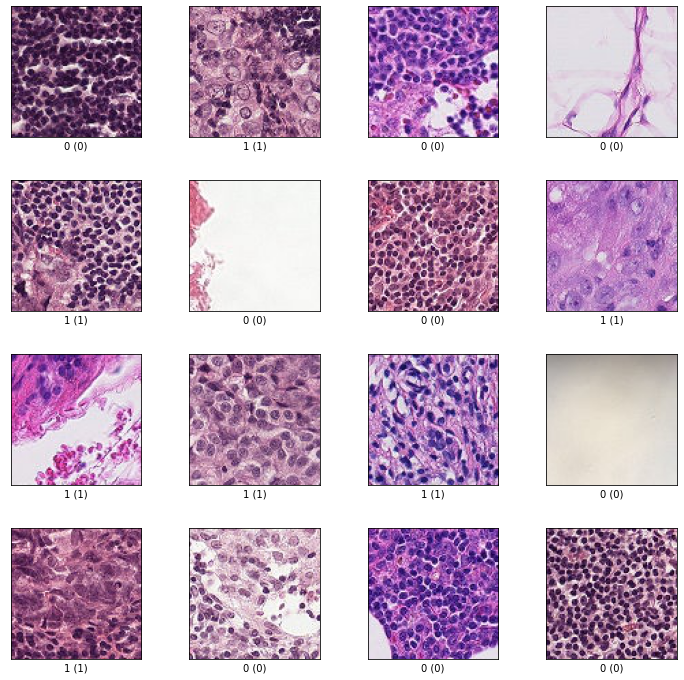

In [5]:
fig = tfds.show_examples(ds_train, ds_info, rows = 4, cols = 4)

In [6]:
def normalize_img(image, label):
  # this will normalize the images
  return tf.cast(image, tf.float16)/255.0, label

In [7]:
def augment(image_label, seed):
  image, label = image_label
  image, label = normalize_img(image, label)
  # I ended up not performing data augmentation as it decreased the accuracy of my model.
  return image, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# When choosing the number of parallel calls for next step, TensorFlow can decide the best value to optimize productivity. 
BATCH_SIZE = 16

In [9]:
counter = tf.data.experimental.Counter()
ds_train = tf.data.Dataset.zip((ds_train, (counter, counter)))

In [10]:
ds_train = ds_train.map(augment, num_parallel_calls = AUTOTUNE)
ds_train = ds_train.cache()
# This will allow some of the data to be kept in memory so it will be loaded more quickly next time
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
# Shuffles data randomly
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)
# Helps increase efficiency, will prepare some examples while the GPU is running

In [11]:
ds_validation = ds_validation.map(normalize_img, num_parallel_calls = AUTOTUNE)
ds_validation = ds_validation.batch(32)
ds_validation = ds_validation.prefetch(AUTOTUNE)

In [12]:
ds_test = ds_test.map(normalize_img, num_parallel_calls = AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.prefetch(AUTOTUNE)

In [13]:
def create_model(image_size = 96):
  inception = InceptionV3(weights = 'imagenet',
                          include_top = False,
                          input_shape = (image_size, image_size, 3))
  
  for layer in inception.layers:
    layer.trainable = False

  model = Sequential()
  model.add(inception)
  model.add(GlobalAveragePooling2D())

  input = Input(shape=(image_size, image_size, 3))

  encoded = model(input)

  dense1 = Dense(256, activation='relu')(encoded)
  batch_normalization1 = BatchNormalization()(dense1)
  drop_layer = tf.keras.layers.Dropout(0.7)(batch_normalization1)
  dense2 = Dense(128, activation='relu')(drop_layer)
  batch_normalization2 = BatchNormalization()(dense2)
  drop_layer2 = tf.keras.layers.Dropout(0.7)(batch_normalization2)

  output = Dense(1, activation='sigmoid')(drop_layer2)
  model = Model(inputs=[input], outputs=output)

  return model

In [14]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_94 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [15]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1)]

In [17]:
model.fit(ds_train,
          batch_size = 16, 
          epochs = 20,
          verbose=1,
          validation_data = (ds_validation),
          callbacks = callbacks
          )

Epoch 1/20
16384/16384 [==============================] - 506s 23ms/step - loss: 0.5698 - accuracy: 0.7245 - val_loss: 0.4617 - val_accuracy: 0.7801
Epoch 2/20
16384/16384 [==============================] - 381s 23ms/step - loss: 0.4958 - accuracy: 0.7670 - val_loss: 0.4522 - val_accuracy: 0.7875
Epoch 3/20
16384/16384 [==============================] - 379s 23ms/step - loss: 0.4797 - accuracy: 0.7769 - val_loss: 0.4414 - val_accuracy: 0.7884
Epoch 4/20
16384/16384 [==============================] - 378s 23ms/step - loss: 0.4706 - accuracy: 0.7826 - val_loss: 0.4369 - val_accuracy: 0.7944
Epoch 5/20
16384/16384 [==============================] - 377s 23ms/step - loss: 0.4656 - accuracy: 0.7855 - val_loss: 0.4366 - val_accuracy: 0.7940
Epoch 6/20
16384/16384 [==============================] - 381s 23ms/step - loss: 0.4591 - accuracy: 0.7901 - val_loss: 0.4339 - val_accuracy: 0.7922
Epoch 7/20
16384/16384 [==============================] - 384s 23ms/step - loss: 0.4560 - accuracy: 0.7911

In [18]:
model.evaluate(ds_test)

1024/1024 [==============================] - 31s 30ms/step - loss: 0.4280 - accuracy: 0.8017


[0.4279716908931732, 0.801666259765625]